Author: Ond\v{r}ej Podsztavek

# Problem Specification

Given whole number $n$ (number of things), whole number $M$ (knapsack capacity),
finite set $W = \{w_1, w_2, \dots , w_n\}$ (things' weights),
finite set $C = \{c_1, c_2, \dots , c_n\}$ (things' price).
Construct set $X = \{x_1, x_2, \dots , x_n\}$ where all $x_i \in \{0, 1\}$,
so that $w_1 x_1 + w_2 x_2 + \dots + w_n x_n \leq M$ (knapsack is not overloaded)
and expression $c_1 x_1 + c_2 x_2 + \dots + c_n x_n$ is maximal for all such sets
(price of things in knapsack is maximal).

# Analysis of Possible Solution Variants

This section provides descriptions of possible methods for solving the knapsack problem:

1. *Brute force method* tries all possible configurations and return optimal solution.
2. *Heuristic method* is based on  inserting things into knapsack according to ratio of price and weight. Solving with heuristic method fills the knapsack fast, but it can find suboptimal solution. 
3. *Branch and bound method* works same as brute force method but provides two optimizations.
4. *Dynamic programming (decomposition by overall cost)* is pseudo-polynomial algorithm and it returns optimal solution.
5. *FPTAS algorithm for knapsack problem* allows to solve the problem with chosen error and the time complexity is not going to grow worse the polynomially.

In [1]:
import knapsack as knap
import ast
import timeit
import time
import glob
import pandas
import numpy
from matplotlib import pyplot
from matplotlib.ticker import FormatStrFormatter
from functools import partial

In [2]:
%matplotlib inline

In [3]:
def read_all_instances():
    instances = dict()
    for filename in glob.iglob('data/knap_??.inst.dat'):
        with open(filename) as f:
            instances.update(knap.read_instances(f))

    return pandas.DataFrame.from_dict(instances, orient='index')

def read_solutions(f):
    data = {}
    for line in f.readlines():
        items = list(map(int, line.split()))
        data[items[0]] = {
            'solution_value': items[2],
            'solution': items[3:]
        }
    return data

def read_all_solutions():
    solutions = dict()
    for filename in glob.iglob('data/knap_??.sol.dat'):
        with open(filename) as f:
            solutions.update(read_solutions(f))
    return pandas.DataFrame.from_dict(solutions, orient='index')

def backup_dataframe():
    # save DataFrame
    df.to_csv('data/dataframe-backup.csv')

def time_instances(fn, ns, df, time_column):
    for n in ns:
        for idx, inst in df[df['n'] == n].iterrows():
            global inst_fn  # TODO global allows to make import from __main__
            inst_fn = partial(fn, *inst[['n', 'm', 'weights', 'values']])
            timer = timeit.Timer('inst_fn()', setup='from __main__ import inst_fn', timer=time.process_time)
            t = timer.timeit(number=1)
            df.loc[idx, time_column] = t
            print(idx, inst['n'], t)

def solve_instances(fn, ns, df, solution_column):
    for n in ns:
        for idx, inst in df[df['n'] == n].iterrows():
            value, _ = fn(*inst[['n', 'm', 'weights', 'values']])
            df.loc[idx, solution_column] = value
            print(idx, inst['n'], value)

In [4]:
# restore DataFrame
generic = lambda x: ast.literal_eval(x)
converters = {
    'weights': generic,
    'values': generic,
    'solution': generic
}
df = pandas.read_csv('data/dataframe-backup.csv', index_col=0, converters=converters)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 9000 to 9599
Data columns (total 20 columns):
n                            600 non-null int64
m                            600 non-null int64
weights                      600 non-null object
values                       600 non-null object
heuristic_time               600 non-null float64
brute_force_time             300 non-null float64
solution_value               600 non-null int64
solution                     600 non-null object
heuristic_value              600 non-null float64
relative_error               600 non-null float64
branch_and_bound_time        600 non-null float64
branch_and_bound_value       600 non-null float64
dynamic_programming_value    600 non-null float64
dynamic_programming_time     600 non-null float64
fptas_0.5_value              600 non-null float64
fptas_0.25_value             600 non-null float64
fptas_0.1_value              600 non-null float64
fptas_0.5_time               600 non-null float64


In [5]:
ns = [4, 10, 15, 20, 22, 25, 27, 30, 32, 35, 37, 40]

## Brute Force Method

This method remembers the best cost of solution and corresponding configurations.
For every configuration it check the constrain and compute the optimization criterion.
Its cost is compared to the best cost computed so far and if needed the best cost is modified.
After testing all configurations the method has the optimal solution saved.
Complexity of this method is $\Theta(n2^n)$ where $n$ is instance size because count of all possible knapsack
fillings is $2^n$ and for each of them constrain and optimization criterion has to be computed in time $\Theta(n)$.

In [6]:
time_instances(knap.brute_force, [], df, 'brute_force_time')

## Heuristic Method

This method calculates ratio of price and weight ($\frac{c_i}{w_i}$) for each thing.
According to this ratio the thing are sorted in descending order
(if the ratio is the same then the lighter thing is preferred).
Things are inserted into the knapsack in the sorted order until the knapsack is full.
Heuristic method's complexity is $O(n\log{n})$ because complexity of sorting Python function `sorted()` is
$O(n\log{n})$ (viz [Timsort](https://en.wikipedia.org/wiki/Timsort))
and complexity of knapsack filling is only $O(n)$.

In [7]:
time_instances(knap.heuristic, [], df, 'heuristic_time')
solve_instances(knap.heuristic, [], df, 'heuristic_value')
df['relative_error'] = (df['solution_value'] - df['heuristic_value']) / df['solution_value']

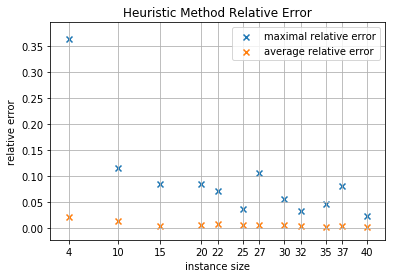

In [8]:
group = df.groupby(by='n')['relative_error']
mean_error = group.mean()
max_error = group.max()

ax = pyplot.subplot()
ax.set_title('Heuristic Method Relative Error')
ax.scatter(ns, max_error, marker='x', label='maximal relative error')
ax.scatter(ns, mean_error, marker='x', label='average relative error')
ax.set_xticks(ns)
ax.set_ylabel('relative error')
ax.set_xlabel('instance size')
ax.legend()
ax.grid()

pyplot.savefig('img/heuristic_relative_error.pdf')

## Branch and Bound

This method works similarly as brute force method. It recursively solves the problem. If in some recursive step the weight of things in knapsack is higher then its capacity the branch is discarded. Secondly, the methods holds the best cost obtained so far. A branch is ended if in some recursive step cost of undecided things cannot improve the best cost. The recursive tree can be pruned a lot but time complexity of this algorithm is still $O(2^n)$.

In [9]:
time_instances(knap.branch_and_bound, [], df, 'branch_and_bound_time')
solve_instances(knap.branch_and_bound, [], df, 'branch_and_bound_value')
(df['branch_and_bound_value'] == df['solution_value']).all()

True

## Dynamic Programming

This method can be implemented in two forms. Decomposition by overall cost or by capacity. Here decomposition by overall cost is measured. Mark $W(i, c)$ as weight of optimal solution with cost $c$ using first $i$ things. These equations hold $W(0, 0) = 0$, $W(0, c) = \inf$ where $c > 0$ and $W(i + 1, c) = \min(W(i, c), W(i, c - c_{i + 1}) + w_{i + 1})$ for all $i > 0$. Then the solution is $W(n, j) \le M$ where $j$ is maximal. This analysis' implementation uses a matrix of size $n \times \sum{c_i}$ which is filled and optimal cost is found according to equations above. Then the optimal configuration is reconstructed. Because matrix size is $n \sum{c_i} \le n \sum{C_m}$ where $C_m = \max\{c_1, c_2, \dots, c_n\}$ and each field can be computed in constant time the time complexity is $O(n^2 C_m)$.

In [10]:
time_instances(knap.dynamic_programming, [], df, 'dynamic_programming_time')
solve_instances(knap.dynamic_programming, [], df, 'dynamic_programming_value')
(df['dynamic_programming_value'] == df['solution_value']).all()

True

## Fully Polynomial-Time Approximation Scheme (FPTAS)

FPTAS algorithm for knapsack problem is polynomial algorithm. By omitting the least significant bits in costs it allows to solve the problem with chosen relative error and the time complexity is guaranteed to grow not more than polynomially. Given required relative error $\epsilon$ the algorithm constructs new instance by modifying each cost $c_i$ according to this equality $c'_i = \lfloor \frac{c_i}{K} \rfloor$ where $K = \epsilon \frac{C_m}{n}$ and $C_m = \max\{c_1, c_2, \dots, c_n\}$. This new instance is then solved by dynamic programming.

In [11]:
for e in [0.5, 0.25, 0.1]:
    time_instances(partial(knap.fptas, relative_error=e), [], df, 'fptas_' + str(e) + '_time')
    solve_instances(partial(knap.fptas, relative_error=e), [], df, 'fptas_' + str(e) + '_value')
    df['fptas_' + str(e) + '_relative_error'] = ((df['solution_value'] - df['fptas_' + str(e) + '_value'])
                                                 / df['solution_value'])

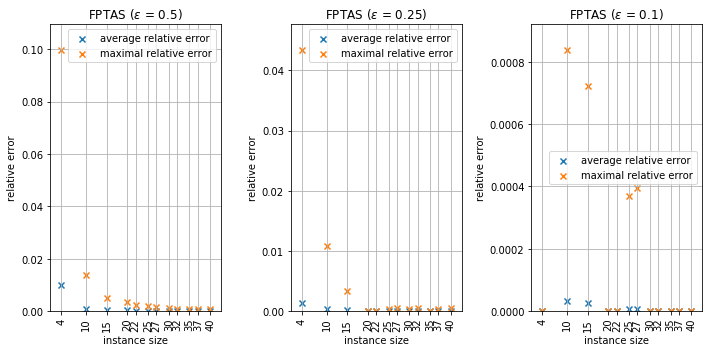

In [12]:
fig, axes = pyplot.subplots(nrows=1, ncols=3, figsize=(10, 5))
for ax, e in zip(axes, [0.5, 0.25, 0.1]):
    group = df.groupby(by='n')['fptas_' + str(e) + '_relative_error']
    mean_error = group.mean()
    max_error = group.max()

    ax.set_ylim([0, 1.1 * df['fptas_' + str(e) + '_relative_error'].max()])
    ax.set_title('FPTAS ($\epsilon$ = ' + str(e) + ')')
    ax.scatter(ns, mean_error, marker='x', label='average relative error')
    ax.scatter(ns, max_error, marker='x', label='maximal relative error')
    ax.set_xticks(ns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.set_ylabel('relative error')
    ax.set_xlabel('instance size')
    ax.legend()
    ax.grid()

fig.tight_layout()
pyplot.savefig('img/fptas_relative_error.pdf')

# Measured Results

Table below contains average CPU time of computations of each instance sizes.
Measuring was carried out on processor *Intel(R) Core(TM) i5-3337U CPU @ 1.80GHz*.
Times for brute force method on instance of size 27 where not possible to measure because of computational complexity.

Figure 1 shows dependence of time on instance size.
Figure 2 shows dependence of relative error on instance size.
Relative error $\epsilon$ is calculated as $\epsilon = \frac{c(\text{opt}) - c(\text{apx})}{c(\text{opt})}$,
where $c(\text{opt})$ is cost of optimal and $c(\text{apx})$ is cost of suboptimal solution.
Figure 3 shows dependence of time on instance size for branch and bound method, dynamic programming and FPTAS algorithm.
Figure 4 shows dependence of relative error on instance size for FPTAS algorithm.

Table below shows the average CPU times for brute force method, heuristic method, branch and bound method and dynamic programming.

instance size | brute force, CPU time ($s$) | heuristic, CPU time ($s$) | branch and bound, CPU time ($s$) | dynamic programming, CPU time ($s$)
--:|-----------:|---------:| --------:|---------:
4  |   0.000038 | 0.000026 | 0.000032 | 0.019083
10 |   0.002232 | 0.000027 | 0.000184 | 0.128957
15 |   0.102152 | 0.000035 | 0.000281 | 0.226531
20 |   3.788610 | 0.000044 | 0.002965 | 0.461762
22 |  16.176022 | 0.000058 | 0.009661 | 0.530528
25 | 138.542621 | 0.000064 | 0.021655 | 0.704964
27 |            | 0.000055 | 0.035915 | 0.772885
30 |            | 0.000059 | 0.117377 | 0.942580
32 |            | 0.000070 | 0.222888 | 1.069233
35 |            | 0.000064 | 0.659761 | 1.259632
37 |            | 0.000058 | 0.737257 | 1.397729
40 |            | 0.000058 | 4.032605 | 1.658905

![Figure 1: Brute force, branch and bound and heuristic method average computational CPU time.](img/brute_force_heuristic_times.pdf)

![Figure 2: Heuristic method relative error.](img/heuristic_relative_error.pdf)

![Figure 3: Branch and bound method, dynamic programming and FPTAS average computational CPU time.](img/bandb_dynamic_fptas.pdf)

![Figure 4: FPTAS algorithm's relative error.](img/fptas_relative_error.pdf)

In [13]:
times_idx = ['brute_force_time', 'heuristic_time', 'branch_and_bound_time', 'dynamic_programming_time',
             'fptas_0.5_time', 'fptas_0.25_time', 'fptas_0.1_time']
times_group = df.groupby(by='n')[times_idx]
times_mean = times_group.mean()
times_std = times_group.std()
times_mean

,brute_force_time,heuristic_time,branch_and_bound_time,dynamic_programming_time,fptas_0.5_time,fptas_0.25_time,fptas_0.1_time
n,,,,,,,
4,0.000038,0.000026,0.000034,0.019083,0.000908,0.001623,0.003787
10,0.002232,0.000027,0.000154,0.128957,0.011387,0.020090,0.050181
15,0.102152,0.000035,0.000292,0.226531,0.037538,0.060854,0.145518
20,3.788610,0.000044,0.002855,0.461762,0.089155,0.140829,0.342327
22,16.176022,0.000058,0.008928,0.530528,0.095749,0.180159,0.478413
25,138.542621,0.000064,0.022785,0.704964,0.135837,0.309871,0.691213
27,NaN,0.000055,0.052917,0.772885,0.164916,0.334847,0.819459
30,NaN,0.000059,0.121398,0.942580,0.239953,0.460975,1.148475
32,NaN,0.000070,0.229006,1.069233,0.311098,0.536905,1.346134


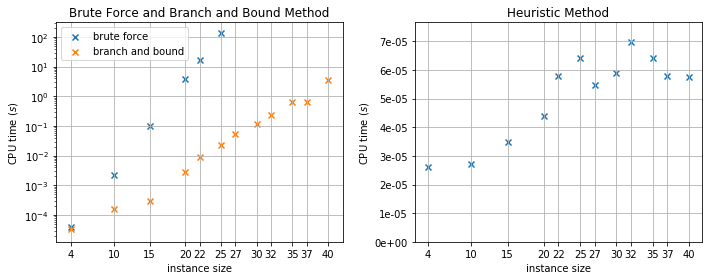

In [14]:
fig, (ax1, ax2) = pyplot.subplots(nrows=1, ncols=2, figsize=(10, 4))
# brute force
ax1.set_yscale('log')
ax1.scatter(ns, times_mean['brute_force_time'], marker='x', label='brute force')
ax1.scatter(ns, times_mean['branch_and_bound_time'], marker='x', label='branch and bound')
ax1.set_title('Brute Force and Branch and Bound Method')
ax1.set_xticks(ns)
ax1.set_xlabel('instance size')
ax1.set_ylabel('CPU time ($s$)')
ax1.legend()
ax1.grid()

# heuristic
ax2.scatter(ns, times_mean['heuristic_time'], marker='x')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.e'))
ax2.set_ylim([0, 1.1 * times_mean['heuristic_time'].max()])
ax2.set_title('Heuristic Method')
ax2.set_xticks(ns)
ax2.set_xlabel('instance size')
ax2.set_ylabel('CPU time ($s$)')
ax2.grid()

fig.tight_layout()
pyplot.savefig('img/brute_force_heuristic_times.pdf')

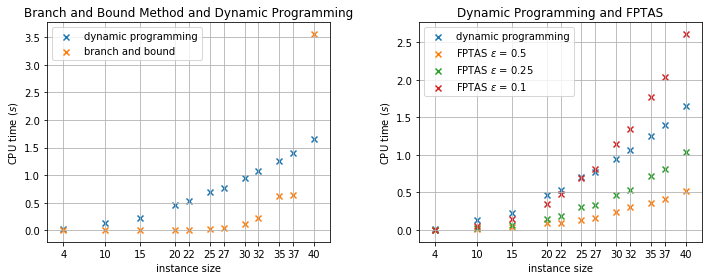

In [15]:
fig, (ax1, ax2) = pyplot.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax1.set_title('Branch and Bound Method and Dynamic Programming')
ax1.scatter(ns, times_mean['dynamic_programming_time'], marker='x', label='dynamic programming')
ax1.scatter(ns, times_mean['branch_and_bound_time'], marker='x', label='branch and bound')

ax2.set_title('Dynamic Programming and FPTAS')
ax2.scatter(ns, times_mean['dynamic_programming_time'], marker='x', label='dynamic programming')
ax2.scatter(ns, times_mean['fptas_0.5_time'], marker='x', label='FPTAS $\epsilon$ = 0.5')
ax2.scatter(ns, times_mean['fptas_0.25_time'], marker='x', label='FPTAS $\epsilon$ = 0.25')
ax2.scatter(ns, times_mean['fptas_0.1_time'], marker='x', label='FPTAS $\epsilon$ = 0.1')

for ax in (ax1, ax2):
    ax.legend()
    ax.set_ylabel('CPU time ($s$)')
    ax.set_xticks(ns)
    ax.set_xlabel('instance size')
    ax.grid()

fig.tight_layout()
pyplot.savefig('img/bandb_dynamic_fptas.pdf')

## Experimental Evaluation of Methods' Quality

This subsection evaluates brute force, branch and bound, dynamic programming and heuristic methods based on instances generated by random generator with different parameters. The aim is to find sensitiveness of the methods to particular types of instances. Test parameters of the random generator are:

- ratio of knapsack's capacity to sum of all things' weight (default to 0.5),
- maximal weight of a thing (default to 250),
- maximal cost of a thing (default to 255),
- $d \in \{-1, 0, 1\}$, where -1 is more lighter things, 0 is balance and 1 is more heavy things (default to 0).

For all methods computational time is observed and for heuristic method also the relative error is observed. Other methods are exact so relative error is not measured.

Instances are generated for one changing parameter while others are set to default. The default values are shown in the list above.

The bars around the points in following plots are standard deviations.

In [16]:
df_20 = df.loc[df['n'] == 20]
df_20['m'].unique(), df_20['weights'].apply(max).max(), df_20['values'].apply(max).max()

(array([250]), 250, 255)

In [17]:
def generate_instance(size, items, i=0, m_ws_ratio=0.5, max_weight=250, max_cost=255, k=1, d=0):
    filename = '/tmp/knap.inst.dat'
    cmd = './knapgen -I {} -n {} -N {} -m {} -W {} -C {} -k {} -d {} > {} 2> /dev/null'.format(
        i, items, size, m_ws_ratio, max_weight, max_cost, k, d, filename
    )
    !$cmd
    
    with open(filename) as f:
        instance = knap.read_instances(f)
    for inst in instance.values():
        inst['m_ws_ratio'] = m_ws_ratio
        inst['max_weight'] = max_weight
        inst['max_cost'] = max_cost
        inst['k'] = k
        inst['d'] = d
    return instance

def generate_instances(m_ws_ratios, max_weights, max_costs, ds, size, items):
    instances = {'m_ws_ratio': {}, 'max_weight': {}, 'max_cost': {}, 'd': {}}
    i = 0
    for v in m_ws_ratios:
        instances['m_ws_ratio'].update(generate_instance(size, items, m_ws_ratio=v, i=i))
        i += size
    for v in max_weights:
        instances['max_weight'].update(generate_instance(size, items, max_weight=v, i=i))
        i += size
    for v in max_costs:
        instances['max_cost'].update(generate_instance(size, items, max_cost=v, i=i))
        i += size
    for v in ds:
        instances['d'].update(generate_instance(size, items, d=v, i=i))
        i += size
    
    dict_of_df = {k: pandas.DataFrame(v).T for k,v in instances.items()}
    return pandas.concat(dict_of_df)
    
    return pandas.DataFrame.from_dict(instances, orient='index')

m_ws_ratios = numpy.linspace(0.1, 0.9, 9)
max_weights = range(50, 251, 25)
max_costs = list(range(50, 251, 25))
ds = [-1, 0, 1]

In [18]:
def experimental_plot(df, index, title, ylim=False):
    means = []
    stds = []
    for param in ['m_ws_ratio', 'max_weight', 'max_cost', 'd']:
        group = df.loc[param].groupby(by=param)[index]
        means.append(group.mean())
        stds.append(group.std())
    
    fig, axs = pyplot.subplots(nrows=2, ncols=2, figsize=(13, 5))
    fig.suptitle(title, fontsize=16)
    for ax, mean, std, xs, name in zip(axs.flat, means, stds,
            [m_ws_ratios, max_weights, max_costs, ds],
            ['capacity to weights sum ratio', 'max weight', 'max cost', 'd']
            ):
        ax.errorbar(xs, mean, yerr=std, fmt='x')
        if ylim:
            ax.set_ylim(bottom=0)
        ax.set_ylabel('CPU time ($s$)')
        ax.set_xticks(xs)
        ax.set_xlabel(name)
        ax.grid()

    pyplot.tight_layout()
    pyplot.subplots_adjust(top=0.9)

In [19]:
exp_30_df = pandas.read_csv('data/exp-30-backup.csv', index_col=[0, 1], converters=converters)
exp_20_df = pandas.read_csv('data/exp-20-backup.csv', index_col=[0, 1], converters=converters)

### Brute Force Method

Figure 6 shows dependence of CPU time to various random generator's parameters. Instance size is 20 items and each point in plot is a mean of 10 instances.

From complexity perspective the computation should only depend on instance size so there show be no differences for changing parameters. But the plot shows that for example capacity to weight sum ration has some influence. This is probably the consequence that if the ratio is high there is lot of different combination which fit into knapsack so that the value of best cost and best things set will change often. On the other hand if the ratio is low there will not be so many changes in best values.

Other parameter should follow the same reasoning which depends on the number of changes in best values but the result are not so clear.

![Figure 6: Experimental evaluation of brute force method.](img/brute_force_exp.pdf)

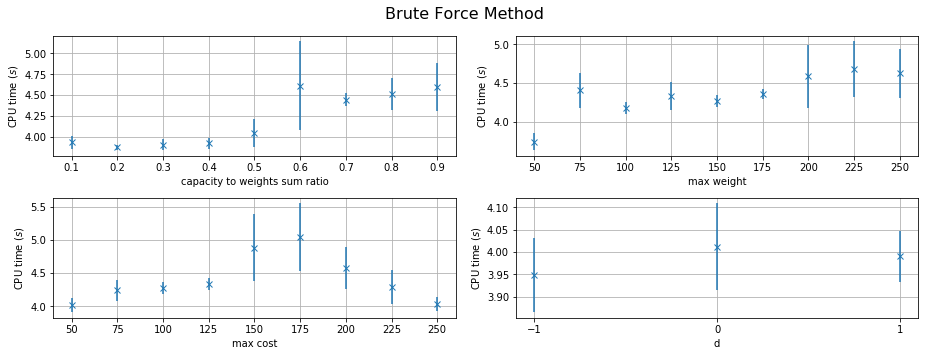

In [20]:
# items = 20
# exp_20_df = generate_instances(m_ws_ratios, max_weights, max_costs, ds, size=10, items=items)
# time_instances(knap.brute_force, [items], exp_20_df, 'brute_force_time')
# exp_20_df.to_csv('data/exp-20-backup.csv')
experimental_plot(exp_20_df, 'brute_force_time', 'Brute Force Method')
pyplot.savefig('img/brute_force_exp.pdf')

### Branch and Bound Method

Branch and bound method was evaluated on same data as brute force method. Figure 7 presents its results.

Branch and bound computational time depend on the ability to prone the recursion tree. Results shows that it is able to do that depending on capacity to weights sum ratio. For low ratio probably because it can prone based on over weighted knapsack and for high ratio probably most branches cannot improve the best value obtained so far.

Secondly, the method works very fast for a lot of soft items but can be very slow for instances with plenty of heavy items.

![Figure 7: Experimental evaluation of branch and bound method.](img/branch_and_bound_exp.pdf)

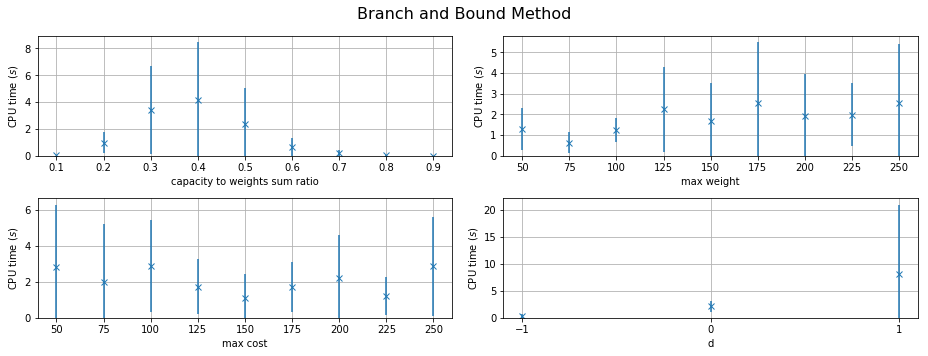

In [21]:
# items = 30
# exp_30_df = generate_instances(m_ws_ratios, max_weights, max_costs, ds, size=10, items=items)
# time_instances(knap.branch_and_bound, [items], exp_30_df, 'branch_and_bound_time')
# exp_30_df.to_csv('data/exp-30-backup.csv')
experimental_plot(exp_30_df, 'branch_and_bound_time', 'Branch and Bound Method', ylim=True)
pyplot.savefig('img/branch_and_bound_exp.pdf')

### Dynamic Programming

Dynamic programming according to the cost is known to be sensitive to max cost. In figure 8 the dependence is clearly presented. Instances on size 30 were measured and the points in plots are averages on 10 instances.

It looks like there is no dependence on max weight and also on the instance's granularity.

Capacity to weights sum ratio plot shows that dynamic programming performs well for either low or high values but not for values in the middle.

![Figure 8: Experimental evaluation of dynamic programming method.](img/dynamic_programming_exp.pdf)

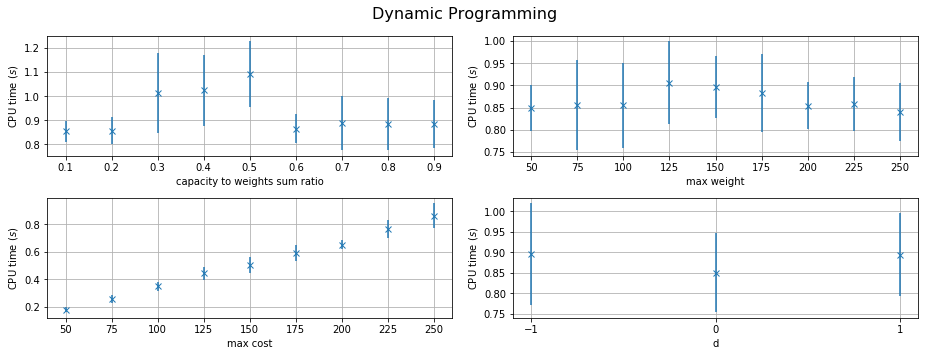

In [22]:
# time_instances(knap.dynamic_programming, [items], exp_30_df, 'dynamic_programming_time')
experimental_plot(exp_30_df, 'dynamic_programming_time', 'Dynamic Programming')
pyplot.savefig('img/dynamic_programming_exp.pdf')

### Heuristic Method

Heuristic method can be evaluated from both computational time and relative error perspective. Figure 9 shows dependence of computational time and figure 10 shows dependence of relative error. Measurements were carried out on instances of size 30, 10 instances for each parameter setting and each value is mean of 25 time measurements

It seems that heuristic method is robust to capacity of weights sum ration, max weight and max cost. But deepens on items granularity. Obviously, if there is more heavy items some of them will have very good cost to weight ratio and therefore the knapsack will be filled faster.

![Figure 9: Experimental evaluation of heuristic method.](img/heuristic_exp.pdf)

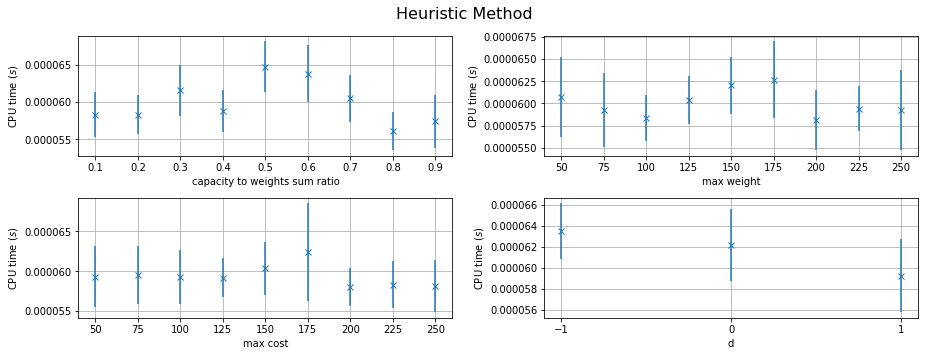

In [23]:
column_names = ['heuristic_time_' + str(i) for i in range(25)]
# items = 30
# for column in column_names:
#     time_instances(knap.heuristic, [items], exp_30_df, column)
# exp_30_df['heuristic_time'] = exp_30_df[column_names].mean(axis=1)
experimental_plot(exp_30_df, 'heuristic_time', 'Heuristic Method')
pyplot.savefig('img/heuristic_exp.pdf')

Relative error of heuristic method depends on capacity to weights sum ratio. Clearly, if the ratio is high almost all thing will be in optimal solution so the error will be low. It looks like it is good to use it for instances with balanced granularity. Max cost and max weight plots show no dependence.

![Figure 10: Experimental evaluation of heuristic method relative error.](img/heuristic_exp_relative_error.pdf)

In [24]:
solve_instances(knap.dynamic_programming, [], exp_30_df, 'dynamic_programming_value')
solve_instances(knap.heuristic, [], exp_30_df, 'heuristic_value')

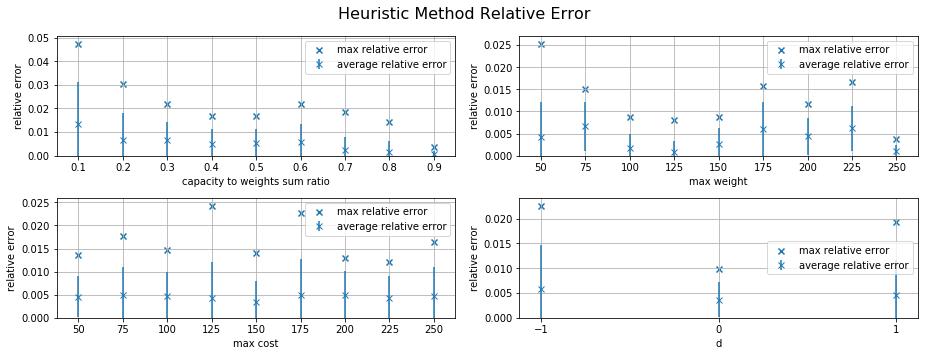

In [25]:
exp_30_df['relative_error'] = (exp_30_df['dynamic_programming_value'] - exp_30_df['heuristic_value']) / exp_30_df['dynamic_programming_value']

means = []
maxs = []
stds = []
for param in ['m_ws_ratio', 'max_weight', 'max_cost', 'd']:
    group = exp_30_df.loc[param].groupby(by=param)['relative_error']
    means.append(group.mean())
    maxs.append(group.max())
    stds.append(group.std())

fig, axs = pyplot.subplots(nrows=2, ncols=2, figsize=(13, 5))
fig.suptitle('Heuristic Method Relative Error', fontsize=16)
for ax, mean, max_value, std, xs, name in zip(axs.flat, means, maxs, stds,
        [m_ws_ratios, max_weights, max_costs, ds],
        ['capacity to weights sum ratio', 'max weight', 'max cost', 'd']
        ):
    ax.errorbar(xs, mean, yerr=std, fmt='x', label='average relative error')
    ax.scatter(xs, max_value, marker='x', label='max relative error')
    ax.set_ylabel('relative error')
    ax.set_ylim(bottom=0)
    ax.set_xticks(xs)
    ax.set_xlabel(name)
    ax.grid()
    ax.legend()

pyplot.tight_layout()
pyplot.subplots_adjust(top=0.9)
pyplot.savefig('img/heuristic_exp_relative_error.pdf')

# Conclusion

From measured data is obvious that for big instances brute force method is not usable
because of vast computational complexity.
On contrary for small instances brute force can find optimal solutions relatively fast.
Same behavior has the branch and bound method. 
For big instances the computational time seems to grow fast
but performance on instances of size 40 and smaller is very good.

Heuristic method is able to solve fast instances of all sizes.
Growth of computational complexity is acceptable.
From figure 2 can be inferred that as size of instance grows so the relative error is smaller
and thus the suboptimal solutions are better.

Because time complexity of dynamic programming grow psedopolynomially it is great method.
Computational time grows slowly
    and if the interested is only in optimal solution price its memory complexity is acceptable for big instances.
But this all holds only if the instances costs are in suitable form.

Partial solution for the problem of dynamic programming is FPTAS algorithm.
By controlling the relative error it is possible to find suboptimal solution fast.
But if the boundary for relative error is too much low
it is slower than dynamic programming which would found optimal solution. This happens when $\epsilon < \frac{n}{C_m}$ then $K < 1$ resulting in the costs of new instance being higher.

Subsection Experimental Evaluation of Methods’ Quality shows that if anything is known about statistical properties of intances methods should be applied to then it is should be use to choose method which best suites. Because else the benefits of a method can be significantly worse.

Overall, branch and bound method is very efficient for small instances. Dynamic programming is great for bigger instances. What is more, FPTAS can shorten the computational time if relative error want to be controlled.